## Baffin Bay  ANHAlysis 
### Preliminary search for Marine Heatwaves on ANHA4 model data.
###### By Emilio Enriquez; Modifiend by Luiz Henrique da Silva

----




In [1]:
# -*- coding: utf-8 -*-


# Data related libraries
import pandas as pd
import datetime
import numpy as np
import netCDF4 as nc

# Plotting related libraries
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from cartopy import crs as ccrs, feature as cfeature
import seaborn as sns
# for interactive ploting
%matplotlib nbagg    

# Machine specific libraries
import sys
import glob
import os


# Project custom made libaries
sys.path.append('/mnt/storage0/luiz/ANALYSES/SCRIPTS/PYTHON/ANHALIZE/anhalyze/')
import anhalyze_utils as au



In [2]:
print('Hello world!')

Hello world!


In [3]:
# Setting up Baffin Bay location
east = -48
west = -81
north = 80
south = 65

lat_range  = (south,north)
lon_range = (west,east)

# Setting up data specific params
year= ['2000','2001']
grid = 'T'# to do: add Options: T, B, U, V, W, and icemod
month_list = ['04','06','08']
day_list = [5,4,3]
depth = 0 # Depth level
var = 'votemper'

In [4]:
    def get_file_list(grid=None, years_list=None, month_list=None, one_per_month=False):
        """  Returns file list given a list of years, a grid type,
             and either all the days in a month, or the first one.
        """

        # Setup
        selected_file_list = []
        monthly_file_list = []
        if month_list is None:
            month_list = []

        # Get paths
        data_path, mask_path = au.get_paths()

        # Get complete file list from path
        file_list = os.listdir(data_path)

        # Selecting list of files given params
        for year in years_list:
            selected_file_list += (sorted([f for f in file_list if '_y'+year in f and '_grid'+grid in f]))

        # Selecting first day on given month
        if one_per_month:
            if not month_list:
                month_list = [get_date(filename, how='m') for filename in selected_file_list]

            for year in years_list:
                for month in month_list:
                    file_name_stump = 'y{}m{}'.format(year, month)
                    file_month_name = [f for f in selected_file_list if file_name_stump in f][0]
                    monthly_file_list.append(file_month_name)
        else:
            # Make month selection
            if month_list:
                for year in years_list:
                    for month in month_list:
                        file_name_stump = 'y{}m{}'.format(year, month)
                        file_month_names = [f for f in selected_file_list if file_name_stump in f]
                        monthly_file_list += file_month_names

        if monthly_file_list:
            selected_file_list = monthly_file_list

        # Adding full path to filenames
        selected_file_list = [data_path+filename for filename in selected_file_list]

        return selected_file_list


In [5]:

# Get file list
file_list = get_file_list(grid=grid, years_list=year, month_list=month_list,one_per_month=True)


In [6]:
def init_location(lat_range,lon_range):
    """
    Setting up model parameters based on user given locations.
    
    """

        # Setting up projection info
        
    standard_parallels = (lat_range[0]+1, lat_range[1]-1)
    central_longitude = (lon_range[0] + lon_range[1])/2


    location_info = {'lat_range': lat_range,
                     'lon_range': lon_range,
                     'standard_parallels': standard_parallels,
                     'central_longitude': central_longitude,
                     # 'proj_size': proj_size,
                     }

    return location_info


In [7]:
def show_var_data_maps(file_list, lat_range, lon_range, depth=depth, var='votemper'):
    """ Displays maps of given parameter (var) in lat-lon range and depth, and date selection.
        Note: depth has not been tested.

       file_list: list of ANHA4 data files in NCDF format. [list]
       lat_range: latitute range [tupple]
       lon_range: longitude range [tupple]
       depth: dep level [int]
       var: variable name [str]
    """
    
    # TODO: check best practices for these global variabbles
    # Setting plotting variables
   
    line_levels = 11
    vmax = 7.
    vmin = -2.
    levels = np.arange(vmin,vmax+0.5)
    #levels = line_levels*len(file_list)
    cmap = 'plasma'
    
    # Setting loop variables.
    lat = None
    lon = None
    data = None

    # Init location info
    # region, proj_size = au.init_location()
    location_info = init_location(lat_range,lon_range)

    # Get date
    date_start = au.get_date(file_list[0])
    date_end = au.get_date(file_list[-1])

    # Setting up figure
    f_size = 4
    ncols = 3
    nrows = int(np.ceil(len(file_list) / ncols))
    fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=[ncols * f_size, nrows * f_size + 1],
                           subplot_kw={'projection': ccrs.LambertConformal(
                                                          central_longitude=location_info['central_longitude'],
                                                          standard_parallels=location_info['standard_parallels'])})

    # Looping over ANHA4 model files
    for i, xx in enumerate(fig.axes):

        # Stop loop when current subplot number is larger than the number of files in list.
        if i == len(file_list):
            break

        # Get ncdf data
        data = nc.Dataset(file_list[i])

        # Get var data from ncdf data
        var_data = au.get_var_data(data, lat_range, lon_range, depth=depth, var=var)

        # Getting lat and lon
        if i == 0:
            lat, lon = au.get_lat_lon(data, lat_range, lon_range)

        # Plotting data
        # Set map extent
        xx.set_extent([lon_range[0], lon_range[1], lat_range[0], lat_range[1]])

        # Set map features
        xx.add_feature(au.get_feature_mask())
        xx.add_feature(au.get_feature_mask(feature='ocean'))

        # Plotting var data as filled contour regions
        im = xx.contourf(lon, lat, var_data, levels=levels, cmap=cmap,
                         vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree(), zorder=2, extend='both')

        # Plotting data contour lines
        xx.contour(lon, lat, var_data, [0], cmap='Greys', linewidths=.2, transform=ccrs.PlateCarree())

        # Create grid-line labels
        gl = xx.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, x_inline=False,
                          y_inline=False, color='k', alpha=.3, linewidths=.01)
        gl.right_labels = gl.top_labels = False

        # Set axis labels
        # To show x label only at the bottom most row
        if i > ncols*(nrows-1)-1:
            xx.text(0.5, -0.22, 'Longitude', va='bottom', ha='center',
                    rotation='horizontal', rotation_mode='anchor',
                    transform=xx.transAxes)
        # To show y label only at left most column
        if i % ncols == 0:
            xx.text(-0.25, 0.55, 'Latitude', va='bottom', ha='center',
                    rotation='vertical', rotation_mode='anchor',
                    transform=xx.transAxes)

        # Set title
        # TODO: change to anha.file_date. If/when moving into class.
        xx.set_title(file_list[i].split('/')[-1].split('_')[1])

        # Set Color-bar
        axins = inset_axes(xx, width="5%", height="100%", loc='right', borderpad=-1)
        lims = [vmin, vmax]
        label = '%s [%s]' % (data.variables[var].long_name.title(), data.variables[var].units.title())
        fig.colorbar(im,cax=axins, orientation="vertical", extend='both',label=label, format='%.1f',)

    # TODO: generlize foor any number of plots. If/when moving into class.
    # Temp fix to plot position given number of plots.
    if len(fig.axes) == 18:
        hspace = .27
    else:
        hspace = .1

    # Add titles to eah figure
    fig.suptitle(data.variables[var].standard_name.replace('_', ' '), fontsize=16)
    # Set up plots positions
    fig.subplots_adjust(bottom=0.1, top=0.9, left=0.07, right=.92, wspace=.65, hspace=hspace)

    # Save figure to file if running in portal (which is a linux system).
    #if platform == "linux" or platform == "linux2":
    #    output_fig_name = '../figs/%s_%s_%s-%s.png' % (location_info['region'],
    #                                                   data.variables[var].long_name,
    #                                                   date_start,
    #                                                   date_end)
    #    plt.savefig(output_fig_name, bbox_inches='tight', dpi=500)



This figure shows examples of ANHA4 data for the months of April, June and August in 2000 and 2001. Here the geographical limits for James Bay are taken arbitrarily as [65,80] in Latitude, and [-48,-81] in Longitude. 


<IPython.core.display.Javascript object>


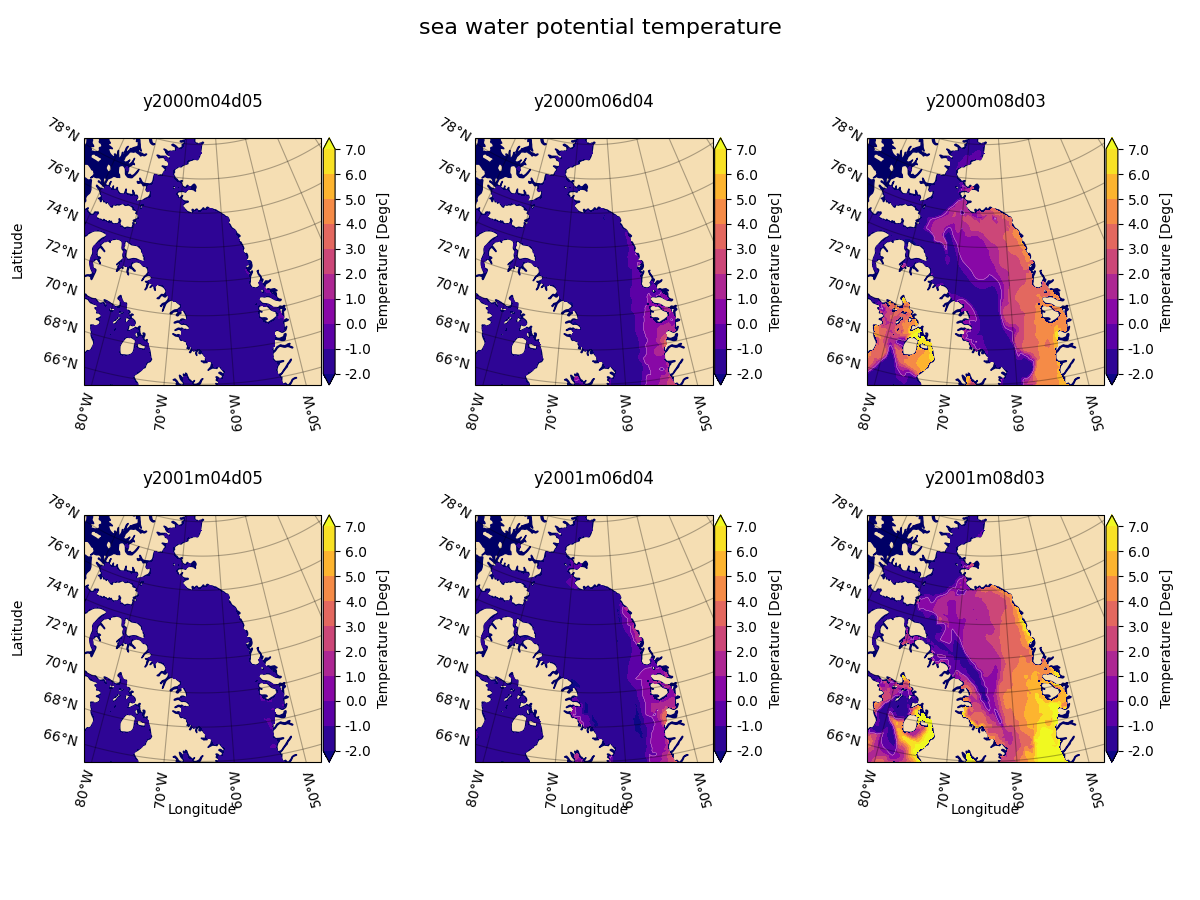

In [8]:
# Show maps for given location in list of files.
show_var_data_maps(file_list,lat_range,lon_range)

In [9]:
def calc_stats_var_data(data, lat_range, lon_range, depth=0, no_min_max=True, var='votemper'):
    """  """

    # Get var data
    var_data = au.get_var_data(data, lat_range, lon_range, depth=depth, var=var)

    # Calculating stats
    var_mean = np.nanmean(var_data)
    var_std = np.nanstd(var_data)

    if no_min_max:
        return var_mean, var_std

    else:
        var_min = np.nanmin(var_data)
        var_max = np.nanmax(var_data)

        return var_mean, var_std, var_min, var_max

In [10]:
data = nc.Dataset(file_list[0])

a, b, c, d = calc_stats_var_data(data, lat_range, lon_range, depth=depth,
                                                                      no_min_max=False, var=var)

In [11]:
d

-0.27556944

In [12]:
def get_timeseries(file_list, lat_range, lon_range, depth=0, no_min_max=True, var='votemper'):
    """    """

    # Setting up
    dates = []
    var_means = []
    var_stds = []
    var_mins = []
    var_maxs = []
    var_min = []
    var_max = []

    # Get datapoints by looping over files
    for filename in file_list:
        # Get ANHA4 data
        data = nc.Dataset(filename)

        # Calculate var_data mean
        if no_min_max:
            var_mean, var_std = calc_stats_var_data(data, lat_range, lon_range, depth=depth,
                                                    no_min_max=no_min_max, var=var)
        else:
            var_mean, var_std, var_min, var_max = calc_stats_var_data(data, lat_range, lon_range, depth=depth,
                                                                      no_min_max=no_min_max, var=var)

        # Save date from filename/time step
        y, m, d = au.get_date(filename, how='ymd')
        date = datetime.date(y, m, d)

        # Append data to timeseries
        var_means.append(var_mean)
        var_stds.append(var_std)
        dates.append(date)
        if not no_min_max:
            var_mins.append(var_min)
            var_maxs.append(var_max)

    # Create timeseries df
    if no_min_max:
        timeseries_var = pd.DataFrame({'date': dates,
                                       'var_mean': var_means,
                                       'var_std': var_stds})
    else:
        timeseries_var = pd.DataFrame({'date': dates,
                                       'var_mean': var_means,
                                       'var_std': var_stds,
                                       'var_min': var_mins,
                                       'var_max': var_maxs})

    return timeseries_var

In [13]:
# Making year list
#year_list = [str(y) for y in np.arange(1958, 2010, 1)]
    
# Make file list from year list    
#file_list = get_file_list(grid=grid, years_list=year_list)

# Get timeseries
#timeseries_var = get_timeseries(file_list,  lat_range, lon_range, depth=depth,no_min_max=False,var=var)


KeyboardInterrupt: 

In [ ]:
# Save data
#timeseries_var.to_csv('/mnt/storage0/luiz/ANALYSES/SCRIPTS/PYTHON/ANHALIZE/project/Baffin_Bay_timeseries_data.csv', index=False)

In order to look for MHWs, four parameters have been extracted from the region described above: mean, standard deviation, minimum and maximum SSTs. The extraction has been done on all currently available data which spans the years 1958 to 2009. 


In [14]:

# Load timeseries data
baffin_bay_timeseries_raw = pd.read_csv('Baffin_Bay_timeseries_data.csv',index_col=False)

# Drop index column
# baffin_bay_timeseries_raw.drop('Unnamed: 0',axis=1,inplace=True)

baffin_bay_timeseries = baffin_bay_timeseries_raw.copy()

# Chage date formating
baffin_bay_timeseries['date'] = pd.to_datetime(baffin_bay_timeseries['date'],format='%Y-%m-%d')

# Add Year column
baffin_bay_timeseries['year'] = baffin_bay_timeseries.date.dt.year

# Add Month column
baffin_bay_timeseries['month'] = baffin_bay_timeseries.date.dt.month

# Add day column
baffin_bay_timeseries['day'] = baffin_bay_timeseries.date.dt.day

# Add wrap-day column
#baffin_bay_timeseries['wrap_day'] = baffin_bay_timeseries.date.dt.strftime('%m-%d')

# # Change date formating
baffin_bay_timeseries['date2'] = baffin_bay_timeseries['date'].dt.date
baffin_bay_timeseries.drop('date',axis=1,inplace=True)
baffin_bay_timeseries.rename(columns={'date2':'date'},inplace=True)

# # Add wrap-day column
baffin_bay_timeseries['wrap_day'] = baffin_bay_timeseries.apply(lambda row: datetime.date(2000,row.month,row.day),axis=1)


In [15]:
baffin_bay_timeseries.head()

,var_mean,var_std,var_min,var_max,year,month,day,date,wrap_day
0,-1.526739,0.507197,-1.901091,2.228462,1958,1,5,1958-01-05,2000-01-05
1,-1.543778,0.477422,-1.981262,3.161615,1958,1,10,1958-01-10,2000-01-10
2,-1.585080,0.432341,-2.066124,3.736827,1958,1,15,1958-01-15,2000-01-15
3,-1.617966,0.386356,-2.103270,3.567802,1958,1,20,1958-01-20,2000-01-20
4,-1.638439,0.406778,-2.094656,3.559473,1958,1,25,1958-01-25,2000-01-25


The graph below shows these values corresponding to the maps above. 
Note that the rest of the analysis focuses on the mean values only. 

<IPython.core.display.Javascript object>


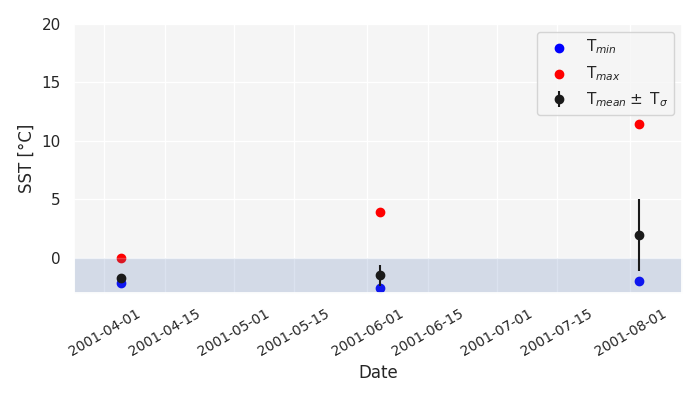

In [16]:
# Making list of dates from above maps
dates = [datetime.date(int(year[1]),int(month),day_list[i]) for i,month in enumerate(month_list)]

# Selecting data given list of dates
baffin_bay_example = baffin_bay_timeseries[baffin_bay_timeseries['date'].isin(dates)]

# Setting up plot
sns.set(rc={'axes.facecolor':'whitesmoke'})
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
ax.xaxis.set_tick_params(rotation=30, labelsize=10)

# Plotting data
plt.errorbar(baffin_bay_example['date'],baffin_bay_example['var_mean'],
             yerr=baffin_bay_example['var_std'],c='k',
             marker='o', linestyle='none', label= 'T$_{mean} \pm$ T$_{\sigma}$')
plt.scatter(baffin_bay_example['date'],baffin_bay_example['var_min'],c='blue', label= 'T$_{min}$')
plt.scatter(baffin_bay_example['date'],baffin_bay_example['var_max'],c='red', label= 'T$_{max}$')

# Set time limits
day_min = datetime.date(int(year[1]),int(month_list[0])-1,day_list[0]+20)
day_max = datetime.date(int(year[1]),int(month_list[-1]),day_list[-1]+10)

plt.ylim([-3,20])
plt.xlim([day_min,day_max])

# Plot frozen zone
plt.fill_between([day_min,day_max],[-3,-3],alpha=.2)

# Plot axis labels
plt.xlabel('Date',fontsize=12)
plt.ylabel('SST [\N{DEGREE SIGN}C]',fontsize=12)
plt.legend()

plt.tight_layout()

In [17]:
# Folding data yearly to get day stats.

baffin_bay_year_mean = baffin_bay_timeseries.groupby('wrap_day')[['var_mean','var_std']].mean().reset_index()
baffin_bay_year_median = baffin_bay_timeseries.groupby('wrap_day')[['var_mean','var_std']].median().reset_index()
baffin_bay_year_quantile = baffin_bay_timeseries.groupby('wrap_day')[['var_mean','var_std']].quantile(.9).reset_index()
baffin_bay_year_max = baffin_bay_timeseries.groupby('wrap_day')[['var_mean','var_std']].max().reset_index()



In [18]:
baffin_bay_year_max.head()

,wrap_day,var_mean,var_std
0,2000-01-05,-1.219780,1.259617
1,2000-01-10,-1.234786,1.194606
2,2000-01-15,-1.264506,1.109275
3,2000-01-20,-1.309643,1.031158
4,2000-01-25,-1.356322,0.937618


ANHA4 data has a five day resolution. Here, I show a 10 year range showing the seasonal distribution of the regional SSTs.


<IPython.core.display.Javascript object>


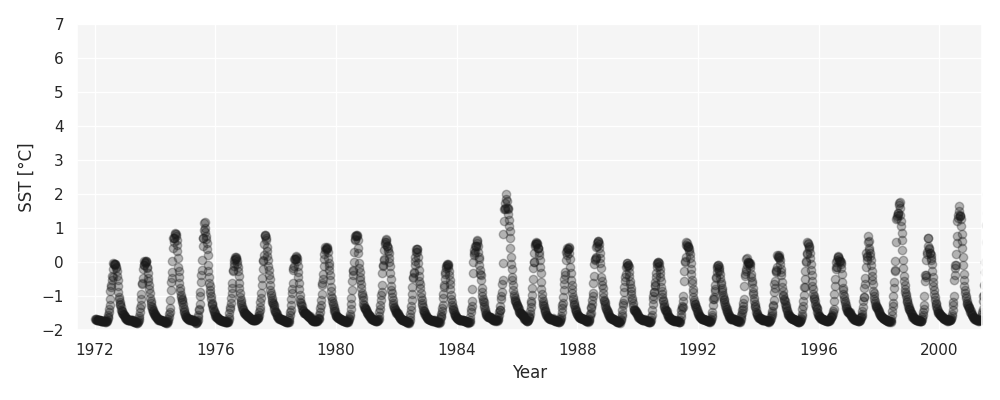

In [20]:

# Selecting data given year range
baffin_bay_timeseries_cut = baffin_bay_timeseries[(baffin_bay_timeseries['year'] > 1971) & (baffin_bay_timeseries['year'] < 2002)]

# Setting up plot
plt.figure(figsize=(10, 4))

# Plotting all data
plt.scatter(baffin_bay_timeseries_cut['date'],baffin_bay_timeseries_cut.var_mean,c='k',alpha=.3)

# Set time limits
day_min = datetime.date(1971,6,1)
day_max = datetime.date(2001,6,1)

plt.ylim([-2,7])
plt.xlim([day_min,day_max])

# Plot frozen zone
plt.fill_between([day_min,day_max],[-2,-2],y2=[-2,-2],alpha=.2)


plt.ylabel(' SST [\N{DEGREE SIGN}C] ')
plt.xlabel('Year')

plt.tight_layout()
plt.show()



The plot below was done by using the whole dataset climatology. It shows the mean SST, T$_{c}$, and the 90th percentile SST, T$_{90}$. Hobday et. al. (2008), uses their difference, $\Delta$T, to calculate the several MHW categories. Category I describes temperatures above T$_{90}$ (or T$_{c}$+ $\Delta$T). Categories II, III and IV are assigned for SST values above T$_{c}$+ 2$\Delta$T, T$_{c}$+ 3$\Delta$T, and T$_{c}$+ 4$\Delta$T, respectively. This plot also shows the maximum value, T$_{Max}$, for every given day present in the data. 

A couple of things are evident. The data contains Category I, II and even III events. There is also a peculiar SSTA in May 20th$^{*}$ that, if following the same definition it would be a Category VII, albeit the lower temperatures. This is mainly due to the earlier thawing, and thus a SST skewed towards freezing values which do not have much temperature variation making $\Delta$T particularly small. In terms of thawing times, for the extreme cases, the zero degree (SST$_{0}$) mark crosses about three weeks earlier than the average in the spring, and about two weeks later than average in the winter. The actual freezing point seems to be at about -1.3 C given the bay's salinity.  


$^{*}$The particular day is from 1998.


<IPython.core.display.Javascript object>


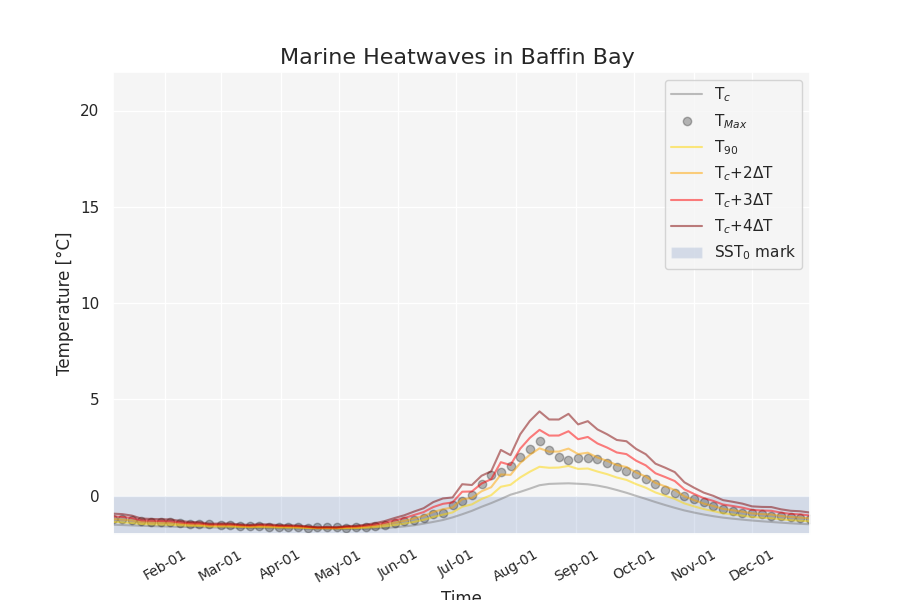

In [23]:
import matplotlib.dates as mdates

# Marine Heatwave plot. Using label sintax from Hobday et. al. 2018.


sns.set(rc={'axes.facecolor':'whitesmoke'})

fig, ax = plt.subplots(1, 1, figsize=(9, 6))

ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
ax.xaxis.set_tick_params(rotation=30, labelsize=10)

plt.plot(baffin_bay_year_mean['wrap_day'],baffin_bay_year_mean['var_mean'],c='gray',alpha=.5,label='T$_{c}$')
plt.plot(baffin_bay_year_max['wrap_day'],baffin_bay_year_max['var_mean'],'o',c='k',alpha=.3,label='T$_{Max}$')

#plt.plot(james_bay_year_median['wrap_day'],james_bay_year_median['var_mean'])
plt.plot(baffin_bay_year_quantile['wrap_day'],
         baffin_bay_year_quantile['var_mean'],
         c='gold',alpha=.5,label='T$_{90}$')
plt.plot(baffin_bay_year_quantile['wrap_day'],
         baffin_bay_year_mean['var_mean']+(baffin_bay_year_quantile['var_mean']-baffin_bay_year_mean['var_mean'])*2,
         c='orange',alpha=.5,label='T$_{c}$+2$\Delta$T')
plt.plot(baffin_bay_year_quantile['wrap_day'],
         baffin_bay_year_mean['var_mean']+(baffin_bay_year_quantile['var_mean']-baffin_bay_year_mean['var_mean'])*3,
         c='red',alpha=.5,label='T$_{c}$+3$\Delta$T')
plt.plot(baffin_bay_year_quantile['wrap_day'],
         baffin_bay_year_mean['var_mean']+(baffin_bay_year_quantile['var_mean']-baffin_bay_year_mean['var_mean'])*4,
         c='maroon',alpha=.5,label='T$_{c}$+4$\Delta$T')

# plt.plot(james_bay_year_quantile['wrap_day'],
#          james_bay_year_mean['var_mean']+(james_bay_year_quantile['var_mean']-james_bay_year_mean['var_mean'])*7,
#          c='k',alpha=.5,label='T$_{c}$+7$\Delta$T')



plt.fill_between([baffin_bay_year_mean['wrap_day'].iloc[0],baffin_bay_year_mean['wrap_day'].iloc[-1]],
                 [0,0],y2=[-2.,-2],alpha=.2,label='SST$_{0}$ mark')
# plt.fill_between([james_bay_year_mean['wrap_day'].iloc[0],james_bay_year_mean['wrap_day'].iloc[-1]],
#                  [-2,-2],y2=[-4.,-4],alpha=.4,facecolor='navy')


plt.ylim([-2,22])
plt.xlim([baffin_bay_year_mean['wrap_day'].iloc[0],baffin_bay_year_mean['wrap_day'].iloc[-1]])

plt.ylabel('Temperature [\N{DEGREE SIGN}C]',fontsize=12)
plt.xlabel('Time',fontsize=12)
plt.title('Marine Heatwaves in Baffin Bay ',fontsize=16)
plt.legend()


plt.show()


In [25]:
# Calculating time series MHW categories and merging them with the time series data itself.

baffin_bay_timeseries['var_mean_mean'] = np.array(baffin_bay_year_mean['var_mean'].to_list()*(2009-1958+1))
baffin_bay_timeseries['var_mean_quantile'] = np.array(baffin_bay_year_quantile['var_mean'].to_list()*(2009-1958+1))
baffin_bay_timeseries['var_mean_2T'] = baffin_bay_timeseries['var_mean_mean']+2*(baffin_bay_timeseries['var_mean_quantile']-baffin_bay_timeseries['var_mean_mean'])
baffin_bay_timeseries['var_mean_3T'] = baffin_bay_timeseries['var_mean_mean']+3*(baffin_bay_timeseries['var_mean_quantile']-baffin_bay_timeseries['var_mean_mean'])
baffin_bay_timeseries['var_mean_4T'] = baffin_bay_timeseries['var_mean_mean']+4*(baffin_bay_timeseries['var_mean_quantile']-baffin_bay_timeseries['var_mean_mean'])


To better analyze the MHWs, T$_{c}$ has been removed from the data. Showing the residual SST shown in the plot below. The highest deviations are seen for years 1998, 2001, 1999, and 2005, starting in order from the highest value. This interestingly coincides with Cree and Inuit accounts, and brings the follow up question to look at the whole Hudson Bay and check for MWH evolution there. 

<IPython.core.display.Javascript object>


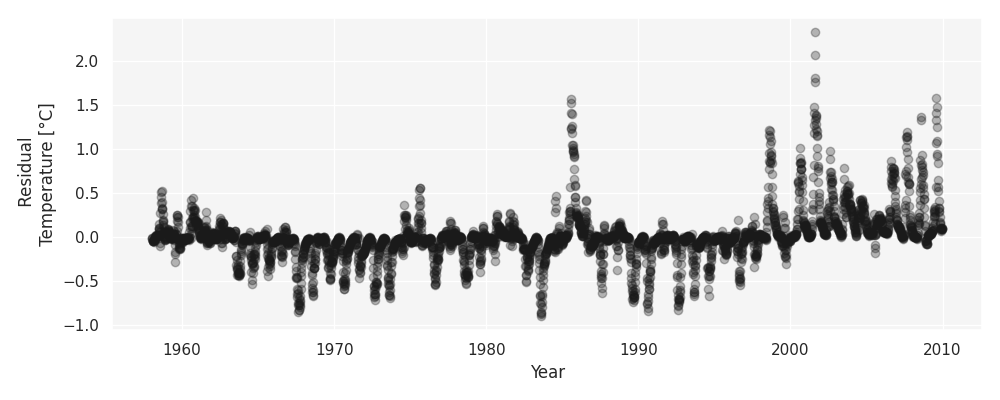

In [27]:
# Removing overal yearly mean to remove seasonal variability. 

plt.figure(figsize=(10, 4))

# Plotting all data
#plt.scatter(james_bay_timeseries['date'],james_bay_timeseries.var_mean,c=james_bay_timeseries.month,cmap='Greys')
plt.scatter(baffin_bay_timeseries['date'],baffin_bay_timeseries.var_mean-baffin_bay_timeseries.var_mean_mean,c='k',alpha=.3)

#max_years = pd.DataFrame([datetime.date(1998,6,1),datetime.date(1999,6,1),datetime.date(2001,6,1),datetime.date(2005,6,1)])
# plt.vlines(max_years, np.array([-6]*4),np.array([6]*4))

plt.ylabel(' Residual\n Temperature [\N{DEGREE SIGN}C] ')
plt.xlabel('Year')

plt.tight_layout()
plt.show()


# The years with the highest positive varibility are: 1998,2001,1999,2005. 
# In that order, based on the single maximum value.


These four years are shown below. All but 1999 present Category II events lasting for a few days, and Category I events lasting for a month or two.  Year 1999 contains Category I events lasting a couple of weeks, with the peak residual SST of 5.4 $^{o}$C (June 14th), making it the year with the 3rd highest. The highest peak residual SST in the model is shown for 1998 at 6.7 $^{o}$C (June 24th).



In [42]:

def plot_year_mhw(timeseries,year=1986,remove_mean=True,show_cat4=False,region="Baffin Bay"):
    """    """
    
    # Selecting year from timeseries
    timeseries_year = timeseries[timeseries['year'] == year].copy()

    if remove_mean:
        labels = ['SST - T$_{c}$','$\Delta$T','2$\Delta$T','3$\Delta$T','4$\Delta$T']
        
        # Get freezing line
        freezing_line = timeseries_year['var_mean_mean']*-1
        # Removing the yealy average T$_{c}$
        timeseries_year['var_mean'] = timeseries_year.apply(lambda row: row.var_mean - row.var_mean_mean,axis=1)
        timeseries_year['var_mean_quantile'] = timeseries_year.apply(lambda row: row.var_mean_quantile - row.var_mean_mean,axis=1)
        timeseries_year['var_mean_2T'] = timeseries_year.apply(lambda row: row.var_mean_2T - row.var_mean_mean,axis=1)
        timeseries_year['var_mean_3T'] = timeseries_year.apply(lambda row: row.var_mean_3T - row.var_mean_mean,axis=1)
        timeseries_year['var_mean_4T'] = timeseries_year.apply(lambda row: row.var_mean_4T - row.var_mean_mean,axis=1)
        
    else:
        labels = ['SST','T$_{90}$','T$_{c}$+2$\Delta$T','T$_{c}$+3$\Delta$T','T$_{c}$+4$\Delta$T']
        
    # Setting up figure
    plt.figure(figsize=(9, 5))

    # Plotting all data

    if not remove_mean:
        plt.plot(timeseries['date'],
                 timeseries.var_mean_mean,
                 c='gray',alpha=.5,label='T$_{c}$')
        
    plt.scatter(timeseries_year['date'],
                timeseries_year.var_mean,
                c='k',alpha=.3,label=labels[0])

    plt.plot(timeseries_year['date'],
             timeseries_year.var_mean_quantile,
             c='gold',alpha=.3,label=labels[1])
    plt.plot(timeseries_year['date'],
             timeseries_year.var_mean_2T,
             c='orange',alpha=.3,label=labels[2])
    plt.plot(timeseries_year['date'],
             timeseries_year.var_mean_3T,
             c='red',alpha=.3,label=labels[3])
    if show_cat4:
        plt.plot(timeseries_year['date'],
                 timeseries_year.var_mean_4T,
                 c='maroon',alpha=.3,label=labels[4])

    # Fill in categories colors
    plt.fill_between(timeseries_year['date'],
                     timeseries_year.var_mean_quantile,
                     y2=timeseries_year.var_mean_2T,
                     alpha=.1,facecolor='gold')

    plt.fill_between(timeseries_year['date'],
                     timeseries_year.var_mean_2T,
                     y2=timeseries_year.var_mean_3T,
                     alpha=.1,facecolor='orange')

    if show_cat4:
        plt.fill_between(timeseries_year['date'],
                         timeseries_year.var_mean_3T,
                         y2=timeseries_year.var_mean_4T,
                         alpha=.1,facecolor='red')    

    if remove_mean:
        plt.fill_between(timeseries_year['date'],freezing_line,alpha=.3,label='SST$_{0}$ mark')
        
    else:
        plt.fill_between(timeseries_year['date'],timeseries_year['var_mean']*0.-2.,alpha=.3,label='Freezing line')

    # Set axis limits and labels
    if remove_mean:
        plt.ylim(bottom=0)
    else:
        plt.ylim(bottom=-2) 
        
    plt.xlim([timeseries_year['date'].iloc[0],timeseries_year['date'].iloc[-1]])
    plt.ylabel(' Residual\n Temperature [\N{DEGREE SIGN}C]',fontsize=12)
    plt.xlabel('Year',fontsize=12)
    plt.title('%s %i MHW'%(region,year),fontsize=16)
    plt.legend()

    plt.tight_layout()
    plt.show()
    

<IPython.core.display.Javascript object>


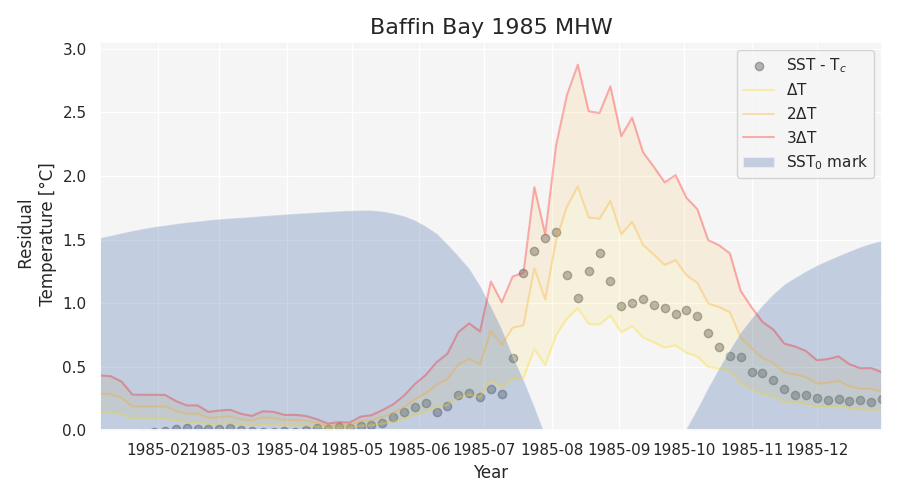

In [43]:
# MHW 1998

year = 1985 

plot_year_mhw(baffin_bay_timeseries,year=year,remove_mean=True,show_cat4=False)


<IPython.core.display.Javascript object>


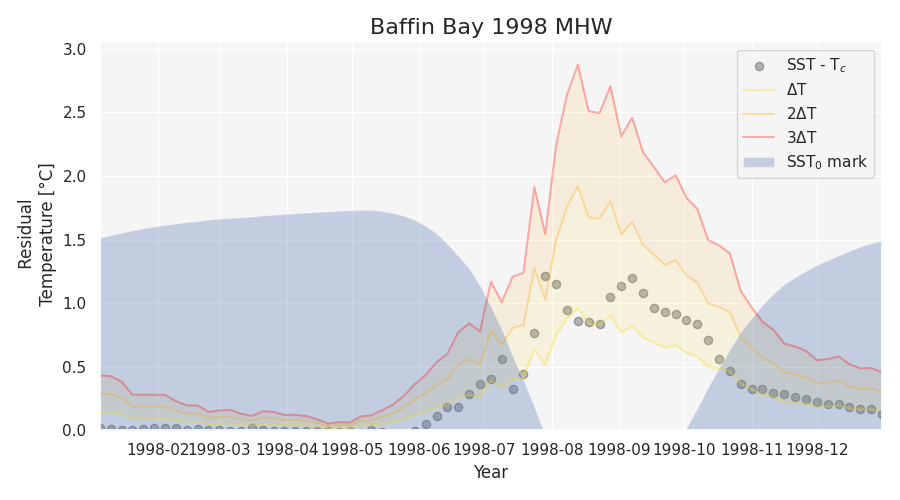

In [48]:
# MHW 

year = 1998

plot_year_mhw(baffin_bay_timeseries,year=year,remove_mean=True,show_cat4=False)


<IPython.core.display.Javascript object>


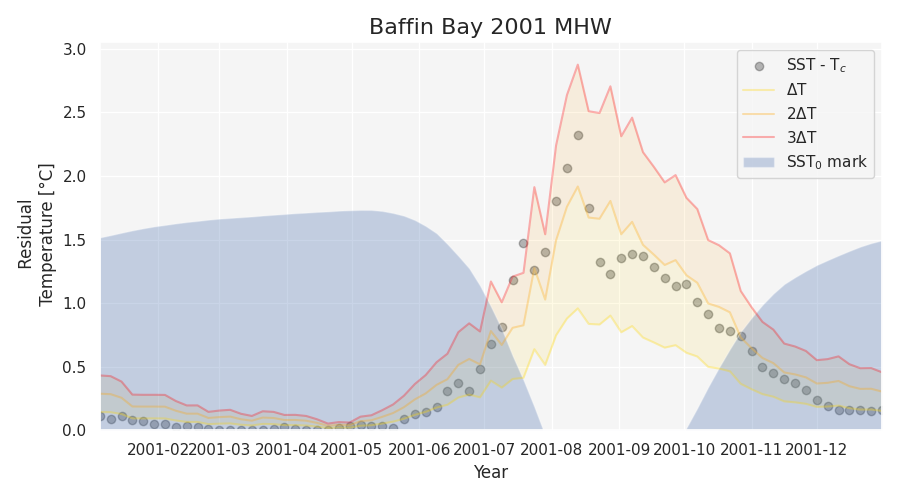

In [49]:
# MHW 

year = 2001

plot_year_mhw(baffin_bay_timeseries,year=year,remove_mean=True,show_cat4=False)


<IPython.core.display.Javascript object>


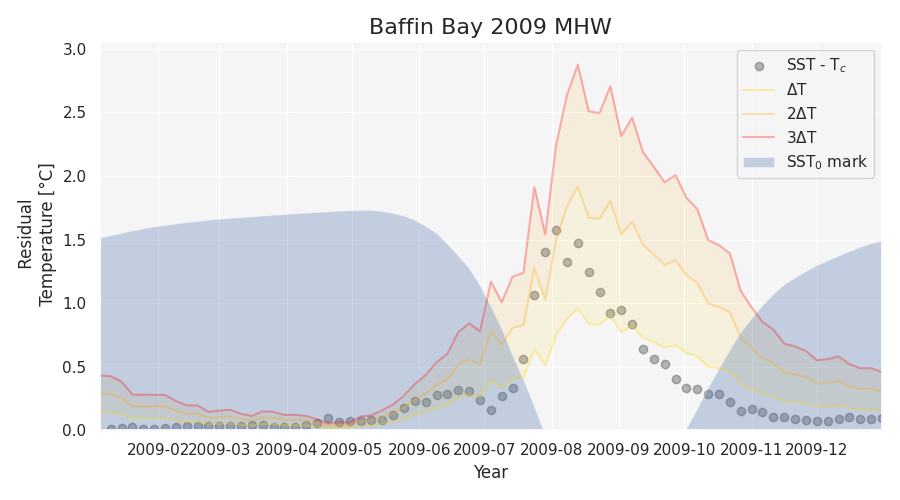

In [46]:
# MHW 

year = 2009 

plot_year_mhw(baffin_bay_timeseries,year=year,remove_mean=True,show_cat4=False)


<IPython.core.display.Javascript object>


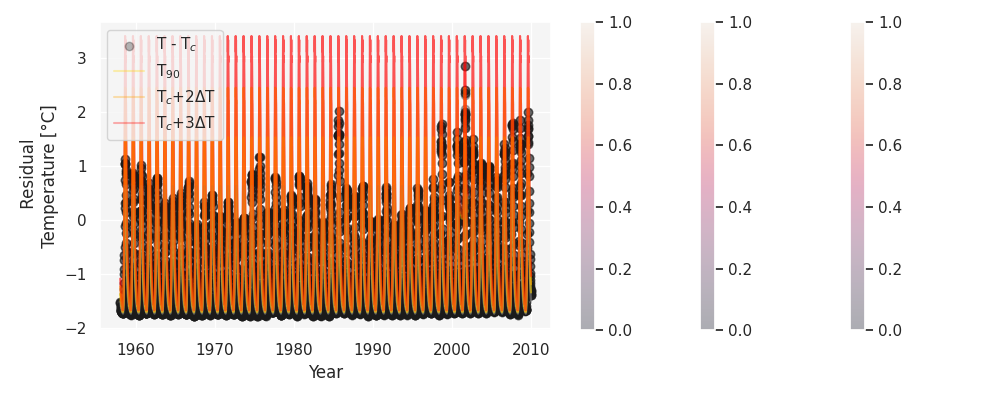

In [50]:
# Showing single year residual variability with respect to the yearly mean.
# 


# Select data from single year.

year = 2001

baffin_bay_timeseries_year = baffin_bay_timeseries[baffin_bay_timeseries['year'] == year].copy()


plt.figure(figsize=(10, 4))


# Plotting all data
#plt.scatter(baffin_bay_timeseries['date'],baffin_bay_timeseries.var_mean,c=baffin_bay_timeseries.month,cmap='Greys')
plt.scatter(baffin_bay_timeseries_year['date'],
            baffin_bay_timeseries_year.var_mean-baffin_bay_timeseries_year.var_mean_mean,
            c='k',alpha=.3,label='T - T$_{c}$')

#plt.plot(baffin_bay_timeseries['date'],baffin_bay_timeseries.var_mean_mean,c='grey',alpha=.3)
plt.plot(baffin_bay_timeseries_year['date'],
         baffin_bay_timeseries_year.var_mean_quantile-baffin_bay_timeseries_year.var_mean_mean,
         c='gold',alpha=.3,label='T$_{90}$')
plt.plot(baffin_bay_timeseries_year['date'],
         baffin_bay_timeseries_year.var_mean_2T-baffin_bay_timeseries_year.var_mean_mean,
         c='orange',alpha=.3,label='T$_{c}$+2$\Delta$T')
plt.plot(baffin_bay_timeseries_year['date'],
         baffin_bay_timeseries_year.var_mean_3T-baffin_bay_timeseries_year.var_mean_mean,
         c='red',alpha=.3,label='T$_{c}$+3$\Delta$T')


plt.fill_between(baffin_bay_timeseries_year['date'],
                 baffin_bay_timeseries_year.var_mean_quantile-baffin_bay_timeseries_year.var_mean_mean,
                 y2=baffin_bay_timeseries_year.var_mean_2T-baffin_bay_timeseries_year.var_mean_mean,
                 alpha=.1,facecolor='gold')

plt.fill_between(baffin_bay_timeseries_year['date'],
                 baffin_bay_timeseries_year.var_mean_2T-baffin_bay_timeseries_year.var_mean_mean,
                 y2=baffin_bay_timeseries_year.var_mean_3T-baffin_bay_timeseries_year.var_mean_mean,
                 alpha=.1,facecolor='orange')


plt.ylabel(' Residual\n Temperature [\N{DEGREE SIGN}C] ')
plt.xlabel('Year')
plt.legend()

plt.tight_layout()

plt.show()


In [51]:
#baffin_bay_timeseries_year

baffin_bay_timeseries_year['var_mean'] = baffin_bay_timeseries_year.apply(lambda row: row.var_mean - row.var_mean_mean,axis=1)

baffin_bay_timeseries_year['var_mean'].mean()


0.5095412168321127

In [53]:
baffin_bay_timeseries_year['date']

3139    2001-01-05
3140    2001-01-10
3141    2001-01-15
3142    2001-01-20
3143    2001-01-25
           ...    
3207    2001-12-11
3208    2001-12-16
3209    2001-12-21
3210    2001-12-26
3211    2001-12-31
Name: date, Length: 73, dtype: object

-----

<IPython.core.display.Javascript object>


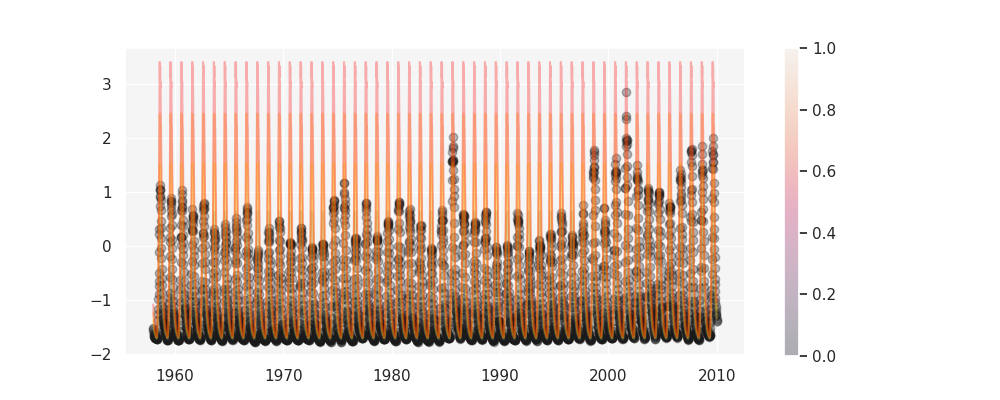

In [60]:

# Plotting all data
#plt.scatter(baffin_bay_timeseries['date'],baffin_bay_timeseries.var_mean,c=baffin_bay_timeseries.month,cmap='Greys')
plt.figure(figsize=(10, 4))
plt.scatter(baffin_bay_timeseries['date'],baffin_bay_timeseries.var_mean,c='k',alpha=.3)

plt.plot(baffin_bay_timeseries['date'],baffin_bay_timeseries.var_mean_mean,c='grey',alpha=.3)
plt.plot(baffin_bay_timeseries['date'],baffin_bay_timeseries.var_mean_quantile,c='gold',alpha=.3)
plt.plot(baffin_bay_timeseries['date'],baffin_bay_timeseries.var_mean_2T,c='orange',alpha=.3)
plt.plot(baffin_bay_timeseries['date'],baffin_bay_timeseries.var_mean_3T,c='red',alpha=.3)



plt.colorbar()

plt.show()


In [ ]:
# Removing overal mean to remove seasonal variability. 


# Plotting all data
#plt.scatter(baffin_bay_timeseries['date'],baffin_bay_timeseries.var_mean-baffin_bay_timeseries.var_mean_mean,c=baffin_bay_timeseries.year,cmap='seismic',alpha=.2)
plt.scatter(baffin_bay_timeseries['date'],baffin_bay_timeseries.var_mean-baffin_bay_timeseries.var_mean_mean,alpha=.2)



plt.colorbar()

plt.show()


In [ ]:
# Plotting folded data montly

james_bay_timeseries.set_index('month', inplace=True)

james_bay_timeseries.groupby('month')['var_mean'].plot(legend=True)

james_bay_timeseries.reset_index(inplace=True)


In [ ]:
# Plot days in single month 

month = 5

james_bay_month = james_bay_timeseries[james_bay_timeseries['month'] == month]

# sns.reset_orig()
# sns.set()

plt.scatter(james_bay_month['day'],james_bay_month['var_mean'],c=james_bay_month['year'],alpha=.8,cmap='tab10')
plt.colorbar()

# Good cmaps to try: tab10 (),  seismic (5,6,8),

In [ ]:

james_bay_timeseries.reset_index(inplace=True)
james_bay_timeseries.set_index('year', inplace=True)

james_bay_timeseries.groupby('month')['var_mean'].plot(legend=True)


james_bay_timeseries.reset_index(inplace=True)


In [ ]:
james_bay_july['day'].unique()